In [49]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy  as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='./Data', train= True, download= True, transform=transform)

100.0%

In [4]:
test_data = datasets.CIFAR10(root='./Data', train= False, download= True, transform=transform)

Files already downloaded and verified


In [5]:
train_data,test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Split: train
     Root Location: ./Data
     Transforms (if any): ToTensor()
     Target Transforms (if any): None,
 Dataset CIFAR10
     Number of datapoints: 10000
     Split: test
     Root Location: ./Data
     Transforms (if any): ToTensor()
     Target Transforms (if any): None)

In [6]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [8]:
class_names

['plane',
 '  car',
 ' bird',
 '  cat',
 ' deer',
 '  dog',
 ' frog',
 'horse',
 ' ship',
 'truck']

In [9]:
for images,labels in train_loader:
    break

In [10]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [    8     5     9     0     7     9     5     0     2     4]
Class:   ship   dog truck plane horse truck   dog plane  bird  deer


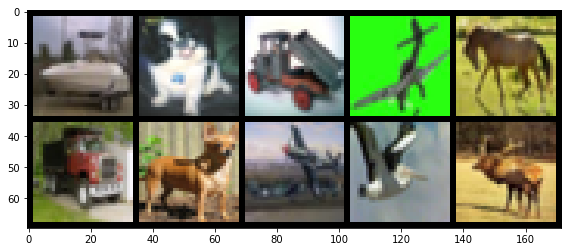

In [12]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [13]:
for i,(X_train,y_train) in enumerate(train_data):
    break

X_train.shape

torch.Size([3, 32, 32])

In [15]:
x = X_train.view(1,3,32,32)

In [16]:
conv1 = nn.Conv2d(3,6,5,1)
conv2 = nn.Conv2d(6,16,3,1)

In [17]:
x = F.relu(conv1(x))
x.shape

torch.Size([1, 6, 28, 28])

In [18]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 6, 14, 14])

In [19]:
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 12, 12])

In [20]:
x = F.max_pool2d(x,2,2)
x.shape

torch.Size([1, 16, 6, 6])

In [23]:
# Why (6x6x16) instead of (5x5x16)?
# With MNIST the kernels and pooling layers resulted in  (((28−2)/2)−2)/2=5.5  which rounds down to 5 pixels per side.
# With CIFAR the result is  (((32−2)/2)−2)/2=6.5  which rounds down to 6 pixels per side.

In [29]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,5,1) #3 is RGB colour channels
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        self.fc1 = nn.Linear(6*6*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [30]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [32]:
#total elements are 81k which is less compared to ANN with MNIST data

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.59612584  accuracy:  27.970%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.31345570  accuracy:  33.475%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.50937414  accuracy:  36.483%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.50948083  accuracy:  38.847%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.67824900  accuracy:  40.548%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.56836891  accuracy:  49.380%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.19723284  accuracy:  49.790%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.58564520  accuracy:  50.327%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.53592849  accuracy:  50.685%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.30315614  accuracy:  51.112%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.53985119  accuracy:  55.960%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.19473696  accuracy:  55.945%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.58711827  accuracy:  55.957%
epoch:  2  b

In [42]:
torch.save(model.state_dict(),'Models/myCIFAR10Model.pt')

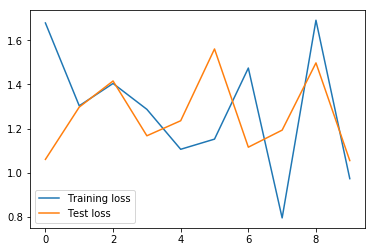

In [43]:
plt.plot(train_losses,label='Training loss')
plt.plot(test_losses,label='Test loss')
plt.legend()

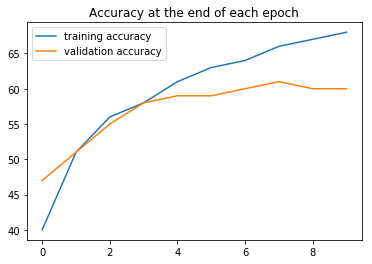

In [44]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [45]:
print(test_correct)

[tensor(4716), tensor(5149), tensor(5523), tensor(5865), tensor(5945), tensor(5973), tensor(6042), tensor(6137), tensor(6020), tensor(6001)]


In [46]:
test_correct[-1]

tensor(6001)

In [47]:
test_correct[-1].item()

6001

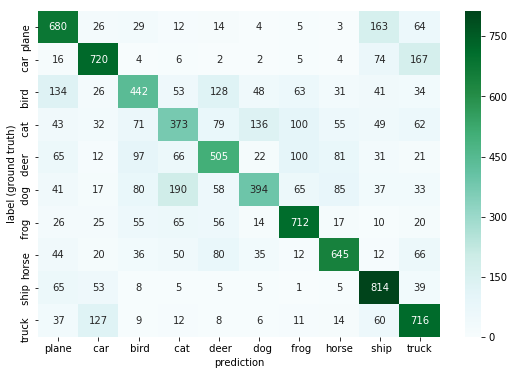

In [50]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();